### 統計學習與深度學習
### Homework 4

請將IPYNB檔與IPYNB Export之HTML檔上傳至COOL作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。

#### Multilayer Perceptrons for Regression
本次作業的主角是 Multilayer perceptrons (MLP)。我們將以MLP建構迴歸模型，探討各項相關議題。


#### Dataset: Million Songs Dataset
本次作業將使用"Million Songs Dataset"作為訓練與測試資料。請使用`pickle.load()`載入*msd_full.pickle*。這個資料集已經切割好了訓練與測試資料，並存放在一個Dictionary的結構。這個Dictionary有四個元素，x_train, y_train, x_test, y_test，分別對應到訓練特徵、訓練標記(Label)、測試特徵、測試標記。 標記變數 (label variable; i.e., $y$) 是歌曲發行年度。特徵為歌曲的聲音特性。迴歸任務為預測歌曲年分。

#### Prediction Performance and Loss Function
模型訓練應主要使用Sum of Squared Error (SSE)建構Loss Function，另外我們也會練習使用其他種類的Loss Function。為了讓圖表易於理解，不論Loss Function為何，報告預測能力應使用Root Mean Squared Error (RMSE)。使用SSE或RMSE建構Loss Function在本質上沒有差別。但SSE計算成本稍低，而RMSE較有直觀意義。


#### Subtraining, Validation, and Test Datasets
*msd_full.pickle* 檔案中的訓練資料已經隨機排序過。你應該使用訓練資料最後10%的資料做為Validation Set。其餘的前90%做為Subtraining Set。使用Subtraining Set來訓練資料，並以Validation Set作為參數調教與Early Stopping的依據。Test RMSE應使用測試資料計算得之。

所有特徵應該標準化(均數為零，變異數為一)。標準化應該以訓練資料(注意不是Test Set or Subtraining Set)的統計量為之。標記變數(i.e., $y$)應將均數平移至0 (依照訓練資料的統計量)。標記變數的變異數不要調整。


#### Minibatch, Epoch, and Early Stopping
如果沒有特別說明，模型訓練時應以大小為1,000個資料點的Minibatch為之。模型使用一個Minibatch的資料更新參數之後稱為經歷了一個Batch。當所有Subtraining資料已經用來更新過模型參數，稱為經過了一個Epoch。

模型訓練應使用Early Stopping決定最佳的模型。模型訓練時每100個Batch計算一次Training and Validation RMSE。如果Validation為歷史最低，則記下當下的模型參數與當時已進行的Batch數量，稱為best_step_count。如由best_step_count起算已經經過了5,000個Batch而沒有更好的Validation RMSE，則停止模型訓練，並以best_step_count時的模型參數做為最後的模型訓練結果。如果模型訓練最多執行100個epoch。如果模型已經執行了100個epoch而沒有Early Stop，則應使用歷史最佳的Validation RMSE所對應到的模型參數計算Test RMSE。


#### Implementation Restriction
使用Pytorch建構MLP模型。Ordinary Least Square (OLS)模型訓練沒有限制使用何種套件。

#### 資料載入
使用下面的程式碼載入資料:

In [2]:
# load packages
%matplotlib inline
import pickle
from sklearn import preprocessing

# Load data
with open('./msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    # standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


# validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)
X_test shape =  (51630, 90)


### 回答下面問題

#### Q1 (5%)
使用Training資料訓練一個Ordinary Least Square模型，並進行預測。列出此模型的RMSE與前五個特徵的參數。OLS模型應包含常數項，且不應有任何Regularization。

#### Q2 MLP with Four Hidden Layers (15%)
建構一個有四層Hidden Layer的MLP。此模型由輸入層開始，90個Input Features通過線性層轉換為H個Hidden Nodes，並通過ReLu Activation Function，此為第一層Hidden Layer。
接著通過下一個線性層與ReLu Activation Function，此為第二層。接著下一個線性層與ReLu Activation Function，此為第三層。
然後下一個線性層與ReLu Activation Function，此為第四層。最後通過一個線性層輸出。
所有Hidden Layer的寬度都為H。

令H= 45, 使用Stochastic Gradient Descent更新參數，設Learning Rate = 0.00001，無Weight Decay與Momentum。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

#### Q3 (10%)
重複上題步驟，使用H = 90與180。無須畫訓練過程的RMSE。列出這兩個Test RMSE。討論H = 45, 90, 180的Test RMSE。

#### Q4 (15%)
使用Q2的模型設定，考慮 H = 45, 90, 180與Weight Decay = 0.1, 0.2, 0.4的所有組合。模型估計後做表整理Test RMSE。討論H的選擇應為多少較合理?

#### Q5 MLP with Dropout (15%)
建構一個有Dropout的四層Hidden Layer的MLP。此模型由輸入層開始，第一層由90個Input Features通過線性層轉換為H個Hidden Nodes，通過ReLu Activation Function，之後對Hidden Unit Dropout，機率為0.5。後面各Hidden Lyaer均在ReLu後有Dropout，機率皆為0.5。最後通過一個線性層輸出。所有Hidden Layer的寬度都為H。

令H= 90, 使用Adaptive Moment Estimation (Adam)更新參數，設Learning Rate = 0.001，無Weight Decay與Momentum，其他參數使用預設值。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

#### Q6 Explore Number of Hidden Units (10%)
使用上題的模型，考慮H = 20, 180, 360。 討論H = 20, 45, 180, 360的Test RMSE。

#### Q7 L2 + L1 Loss (15%)
我們前面的小題皆是使用SSE，也就是L2 Loss。一個改善模型訓練的方式是使用多種類似的Loss，以線性組合的方式建構Loss Function。請使用Q5中的MLP with Dropout模型 (H = 90)，並以L2 + L1 Loss訓練模型。這個Loss的定義如下:

$$
loss(\mathbf{y}, \hat{\mathbf{y}}) = z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i = 1}^n | y_i - \hat{y}_i |,
$$
其中z為實數且$0 <=z <= 1$。

使用z = 0.5。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.0, 0.1, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。

#### Q8 L2 + Customerized Loss (15%)
考慮另一個比較特別的Loss Function

$$
qloss(\mathbf{y}, \hat{\mathbf{y}}) = \sum_{i=1}^n \{ q (y_i - \hat{y}_i)_+ + (1 - q) (\hat{y}_i - y_i)_+ \},
$$
其中q為參數且$0<=q<=1$，而$(y_i - \hat{y}_i)_+$是取正值的意思。也就是說如果$(y_i - \hat{y}_i) > 0$，則$(y_i - \hat{y}_i)_+ = y_i - \hat{y}_i$，否則$(y_i - \hat{y}_i)_+ = 0$。

令模型的Loss為$z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i=1}^n \{ 0.5 (y_i - \hat{y}_i)_+ + 0.5 (\hat{y}_i - y_i)_+ \} $。請使用Q5中的MLP with Dropout模型(H = 90)，令z = 0。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.1, 0.5, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。


## Q1
使用Training資料訓練一個Ordinary Least Square模型，並進行預測。列出此模型的RMSE與前五個特徵的參數。OLS模型應包含常數項，且不應有任何Regularization。

In [3]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(X_train, Y_train)
Y_pred1 = ols.predict(X_test)

In [4]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse1 = sqrt(mean_squared_error(Y_test, Y_pred1))

print(f'RMSE: {rmse1}')
print(f'coef of first 5 features: {ols.coef_[:5]}')

RMSE: 9.510160684544399
coef of first 5 features: [ 5.30975265 -2.88088114 -1.53234348  0.05737583 -0.33952889]


## Q2
建構一個有四層Hidden Layer的MLP。此模型由輸入層開始，90個Input Features通過線性層轉換為H個Hidden Nodes，並通過ReLu Activation Function，此為第一層Hidden Layer。
接著通過下一個線性層與ReLu Activation Function，此為第二層。接著下一個線性層與ReLu Activation Function，此為第三層。
然後下一個線性層與ReLu Activation Function，此為第四層。最後通過一個線性層輸出。
所有Hidden Layer的寬度都為H。

令H= 45, 使用Stochastic Gradient Descent更新參數，設Learning Rate = 0.00001，無Weight Decay與Momentum。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, in_dim = 90, num_hidden = 45, out_dim = 1):
        '''
        num_layers: number of layers in the neural networks (EXCLUDING the input layer)
        input_dim: dimensionality of input features
        num_hidden: number of hidden nodes in each layer
        output_dim: number of classes for prediction
        '''
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_dim, num_hidden), # layer 1
            nn.ReLU(inplace=True),
            nn.Linear(num_hidden, num_hidden), # layer 2
            nn.ReLU(inplace=True),
            nn.Linear(num_hidden, num_hidden), # layer 3
            nn.ReLU(inplace=True),
            nn.Linear(num_hidden, out_dim) # layer 4
        )

    def forward(self, x):
        x = self.layer(x)
        return x

In [6]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# transform to torch tensor
tensor_x_train = torch.Tensor(X_subtrain) 
tensor_y_train = torch.Tensor(Y_subtrain)

tensor_x_valid = torch.Tensor(X_valid)
tensor_y_valid = torch.Tensor(Y_valid)

tensor_x_test = torch.Tensor(X_test)
tensor_y_test = torch.Tensor(Y_test)

# create 2 datasets
dataset_train = TensorDataset(tensor_x_train, tensor_y_train) 
dataset_valid = TensorDataset(tensor_x_valid, tensor_y_valid)
dataset_test = TensorDataset(tensor_x_test, tensor_y_test)

In [7]:
def validation(model, device, valid_loader, loss_function):
    # Settings
    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for data in valid_loader:
            inputs = data[0].to(device)
            labels = data[1].to(device)
            outputs = model(inputs.view(inputs.shape[0], -1))
            outputs = outputs.squeeze(-1) # let outputs and labels have same size
            loss = loss_function(outputs, labels)
            loss_total += loss.item()

    return loss_total / len(valid_loader)

In [8]:
import math
import copy

# Train
def train(device, model, epochs, optimizer, loss_function, train_loader, valid_loader):
    valid_rmse_list = []
    train_rmse_list = []

    min_valid_loss = 10000
    best_step_count = 0
    best_model = model
    rmse_update_count = 0
    
    for epoch in range(1, epochs+1):
        model.train()
        valid_rmse_epoch = []
        train_rmse_epoch = []

        for batch, data in enumerate(train_loader, 1):
            inputs = data[0].to(device)
            labels = data[1].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            outputs = model(inputs.view(inputs.shape[0], -1))
            outputs = outputs.squeeze(-1) # let outputs and labels have same size
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            # Show progress per 100 batch
            if batch % 100 == 0:
                current_valid_loss = validation(model, device, valid_loader, loss_function)
                current_train_loss = loss.item()
                # print('[epoch {}/{}, batch {}/{}] training RMSE: {:.8}, validation RMSE: {:.8}'.format(epoch, epochs, batch, len(train_loader), sqrt(current_train_loss), sqrt(current_valid_loss)))

                valid_rmse_epoch.append(sqrt(current_valid_loss))
                train_rmse_epoch.append(sqrt(current_train_loss))

                if current_valid_loss < min_valid_loss:
                    best_step_count = batch
                    min_valid_loss = current_valid_loss
                    best_model = copy.deepcopy(model) #deepcopy
                    rmse_update_count = 0
                else:
                    rmse_update_count += 1
                

                if rmse_update_count > 5000:  # Early stopping
                    return best_model, valid_rmse_list, train_rmse_list

        train_rmse_list.append(sum(train_rmse_epoch) / len(train_rmse_epoch))
        valid_rmse_list.append(sum(valid_rmse_epoch) / len(valid_rmse_epoch))

    return best_model, valid_rmse_list, train_rmse_list

In [9]:
from sklearn.metrics import mean_squared_error
def test(model, tensor_x_test, y_true):
    y_pred = model(tensor_x_test).detach().numpy()
    test_rmse = mean_squared_error(y_true, y_pred, squared=False)
    return y_pred, test_rmse

In [10]:
# GPU device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)

# Settings
torch.manual_seed(123) # set the seed
epochs = 100
batch_size = 1000
learning_rate = 0.00001
loss_function = nn.MSELoss()
mlp_model = MLP(in_dim=X_train.shape[1], num_hidden=45, out_dim=1).to(device)
optimizer = torch.optim.SGD(params=mlp_model.parameters(), lr=learning_rate, momentum=0, weight_decay=0) # Stochastic Gradient Descent

# Data
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True)
valid_loader = DataLoader(dataset_valid, batch_size=1000, shuffle=True)

# Train
model2, valid_rmse_list, train_rmse_list= train(device, mlp_model, epochs, optimizer, loss_function, train_loader, valid_loader)

Device state: cpu


Answer:
訓練過程中，每一百個batch計算一次training和validation RMSE，並在該epoch結束時計算此epoch的training和validation RMSE平均值，畫出RMSE與epoch的分布圖。

Test RMSE: 10.738432884216309


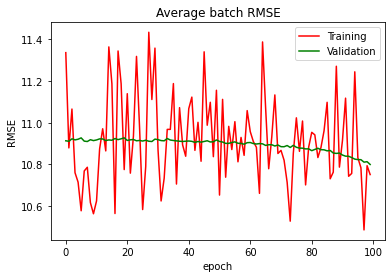

In [11]:
# Test and show the result
import matplotlib.pyplot as plt
predicted, test_rmse = test(model2, torch.Tensor(X_test), Y_test)
print(f'Test RMSE: {test_rmse}')

plt.plot(train_rmse_list, color='red', label='Training')
plt.plot(valid_rmse_list, color='green', label='Validation')
plt.title('Average batch RMSE')
plt.xlabel('epoch') # title of x-axis
plt.ylabel('RMSE') # tile of y-axis
plt.legend()
plt.show()



Training data的平均RMSE雖然沒有根據epoch遞減，但是Validation data的平均RMSE則隨著epoch遞減，可見模型訓練效果隨著epoch上升而更好。

## Q3
重複上題步驟，使用H = 90與180。無須畫訓練過程的RMSE。列出這兩個Test RMSE。討論H = 45, 90, 180的Test RMSE。

H=90

In [12]:
# Settings
torch.manual_seed(123) # set the seed
epochs = 100
batch_size = 1000
learning_rate = 0.00001
loss_function = nn.MSELoss()
mlp_model = MLP(in_dim=X_train.shape[1], num_hidden=90, out_dim=1).to(device)
optimizer = torch.optim.SGD(params=mlp_model.parameters(), lr=learning_rate, momentum=0, weight_decay=0) # Stochastic Gradient Descent

# Data
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True)
valid_loader = DataLoader(dataset_valid, batch_size=1000, shuffle=True)

# Train
model3_1, valid_rmse_list3_1, train_rmse_list3_1 = train(device, mlp_model, epochs, optimizer, loss_function, train_loader, valid_loader)

H=180

In [21]:
mlp_model2 = MLP(in_dim=X_train.shape[1], num_hidden=180, out_dim=1).to(device)
optimizer = torch.optim.SGD(params=mlp_model2.parameters(), lr=learning_rate, momentum=0, weight_decay=0)
model3_2, valid_rmse_list3_2, train_rmse_list3_2 = train(device, mlp_model2, epochs, optimizer, loss_function, train_loader, valid_loader)

Answer

In [22]:
predicted2, test_rmse2 = test(model2, torch.Tensor(X_test), Y_test)
predicted3_1, test_rmse3_1 = test(model3_1, torch.Tensor(X_test), Y_test)
predicted3_2, test_rmse3_2 = test(model3_2, torch.Tensor(X_test), Y_test)

print(f'Test RMSE (H=45): {test_rmse2}')
print(f'Test RMSE (H=90): {test_rmse3_1}')
print(f'Test RMSE (H=180): {test_rmse3_2}')

Test RMSE (H=45): 10.738432884216309
Test RMSE (H=90): 10.61322021484375
Test RMSE (H=180): 9.94489860534668


由以上三個Test RMSE的結果可知H=180時效果最好，H=90次之，H=45則是墊底，所以H越大表現越好。

## Q4
使用Q2的模型設定，考慮 H = 45, 90, 180與Weight Decay = 0.1, 0.2, 0.4的所有組合。模型估計後做表整理Test RMSE。討論H的選擇應為多少較合理?

H=45

In [19]:
rmse_45 = []

for w in [0.1, 0.2, 0.4]:
    mlp_model4_45 = MLP(in_dim=X_train.shape[1], num_hidden=45, out_dim=1).to(device)
    optimizer = torch.optim.SGD(params=mlp_model4_45.parameters(), lr=learning_rate, momentum=0, weight_decay=w) # Stochastic Gradient Descent
    model4_45, valid_rmse_list4_45, train_rmse_list4_45 = train(device, mlp_model4_45, epochs, optimizer, loss_function, train_loader, valid_loader)
    predicted4_45, test_rmse4_45 = test(model4_45, torch.Tensor(X_test), Y_test)
    rmse_45.append(test_rmse4_45)
    print(f'H=45 | w={w} Finished.')

H=45 | w=0.1 Finished.
H=45 | w=0.2 Finished.
H=45 | w=0.4 Finished.


In [23]:
rmse_45

[10.832621, 10.83283, 10.843551]

H=90

In [24]:
rmse_90 = []

for w in [0.1, 0.2, 0.4]:
    mlp_model4_90 = MLP(in_dim=X_train.shape[1], num_hidden=90, out_dim=1).to(device)
    optimizer = torch.optim.SGD(params=mlp_model4_90.parameters(), lr=learning_rate, momentum=0, weight_decay=w) # Stochastic Gradient Descent
    model4_90, valid_rmse_list4_90, train_rmse_list4_90 = train(device, mlp_model4_90, epochs, optimizer, loss_function, train_loader, valid_loader)
    predicted4_90, test_rmse4_90 = test(model4_90, torch.Tensor(X_test), Y_test)
    rmse_90.append(test_rmse4_90)
    print(f'H=90 | w={w} Finished.')

H=90 | w=0.1 Finished.
H=90 | w=0.2 Finished.
H=90 | w=0.4 Finished.


In [18]:
rmse_90

[10.851468, 10.85165, 10.853459]

H=180

In [25]:
rmse_180 = []

for w in [0.1, 0.2, 0.4]:
    mlp_model4_180 = MLP(in_dim=X_train.shape[1], num_hidden=180, out_dim=1).to(device)
    optimizer = torch.optim.SGD(params=mlp_model4_180.parameters(), lr=learning_rate, momentum=0, weight_decay=w) # Stochastic Gradient Descent
    model4_180, valid_rmse_list4_180, train_rmse_list4_180 = train(device, mlp_model4_180, epochs, optimizer, loss_function, train_loader, valid_loader)
    predicted4_180, test_rmse4_180 = test(model4_180, torch.Tensor(X_test), Y_test)
    rmse_180.append(test_rmse4_180)
    print(f'H=180 | w={w} Finished.')

H=180 | w=0.1 Finished.
H=180 | w=0.2 Finished.
H=180 | w=0.4 Finished.


In [26]:
rmse_180

[10.143982, 10.427112, 10.74724]

In [27]:
import pandas as pd

df = pd.DataFrame({'weight decay': [0.1, 0.2, 0.4], 'H=45': rmse_45, 'H=90': rmse_90, 'H=180': rmse_180})
df

,weight decay,H=45,H=90,H=180
0,0.1,10.832621,10.758509,10.143982
1,0.2,10.832830,10.794532,10.427112
2,0.4,10.843551,10.793014,10.747240


由上表得知最佳組合是(H=180, weight decay=0.1)，而H=180的三個Test RMSE皆比H=45、90還要好，所以選擇180最合適。

## Q5
建構一個有Dropout的四層Hidden Layer的MLP。此模型由輸入層開始，第一層由90個Input Features通過線性層轉換為H個Hidden Nodes，通過ReLu Activation Function，之後對Hidden Unit Dropout，機率為0.5。後面各Hidden Lyaer均在ReLu後有Dropout，機率皆為0.5。最後通過一個線性層輸出。所有Hidden Layer的寬度都為H。

令H= 90, 使用Adaptive Moment Estimation (Adam)更新參數，設Learning Rate = 0.001，無Weight Decay與Momentum，其他參數使用預設值。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

In [28]:
class MLP_dropout(nn.Module):
    def __init__(self, in_dim = 90, num_hidden = 45, out_dim = 1):
        '''
        num_layers: number of layers in the neural networks (EXCLUDING the input layer)
        input_dim: dimensionality of input features
        num_hidden: number of hidden nodes in each layer
        output_dim: number of classes for prediction
        '''
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_dim, num_hidden), # layer 1
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(num_hidden, num_hidden), # layer 2
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(num_hidden, num_hidden), # layer 3
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(num_hidden, out_dim) # layer 4
        )

    def forward(self, x):
        x = self.layer(x)
        return x

In [29]:
# GPU device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)

# Settings
torch.manual_seed(123) # set the seed
epochs = 100
batch_size = 1000
learning_rate = 0.001
loss_function = nn.MSELoss()
mlp_drop = MLP_dropout(in_dim=X_train.shape[1], num_hidden=90, out_dim=1).to(device)
optimizer = torch.optim.SGD(params=mlp_drop.parameters(), lr=learning_rate, momentum=0, weight_decay=0) # Stochastic Gradient Descent

# Data
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True)
valid_loader = DataLoader(dataset_valid, batch_size=1000, shuffle=True)

# Train
model_drop, valid_rmse_list5, train_rmse_list5 = train(device, mlp_drop, epochs, optimizer, loss_function, train_loader, valid_loader)

Device state: cpu


Test RMSE: 8.820798873901367


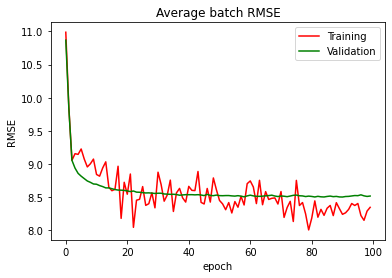

In [30]:
# Test and show the result
import matplotlib.pyplot as plt
predicted5, test_rmse5 = test(model_drop, torch.Tensor(X_test), Y_test)
print(f'Test RMSE: {test_rmse5}')

plt.plot(train_rmse_list5, color='red', label='Training')
plt.plot(valid_rmse_list5, color='green', label='Validation')
plt.title('Average batch RMSE')
plt.xlabel('epoch') # title of x-axis
plt.ylabel('RMSE') # tile of y-axis
plt.legend()
plt.show()

Training data的RMSE有隨著epoch降低的趨勢了，loss剛開始都很高，經過幾個epoch後就驟降。而Validation data的RMSE在epoch 20以後幾乎沒有再下降了。另外，Test RMSE也比Q2的無dropout還要更低。

## Q6
使用上題的模型，考慮H = 20, 180, 360。 討論H = 20, 45, 180, 360的Test RMSE。

In [ ]:
test_rmse_list6 = []

for h in [20, 45, 180, 360]:
    # Setting
    torch.manual_seed(123) # set the seed
    epochs = 100
    batch_size = 1000
    learning_rate = 0.001
    loss_function = nn.MSELoss()
    mlp_drop = MLP_dropout(in_dim=X_train.shape[1], num_hidden=h, out_dim=1).to(device)
    optimizer = torch.optim.SGD(params=mlp_drop.parameters(), lr=learning_rate, momentum=0, weight_decay=0) # Stochastic Gradient Descent
    
    # Train
    model_drop, valid_rmse_list6, train_rmse_list6 = train(device, mlp_drop, epochs, optimizer, loss_function, train_loader, valid_loader)
    
    # Test
    predicted6, test_rmse6 = test(model_drop, torch.Tensor(X_test), Y_test)
    test_rmse_list6.append(test_rmse6)